<a href="https://colab.research.google.com/github/algroznykh/notebooks/blob/master/moderngl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install moderngl

     |████████████████████████████████| 670 kB 4.7 MB/s 
     |████████████████████████████████| 64 kB 1.9 MB/s 


In [17]:
gridgl = """
// %%VARIABLE%% will be replaced with consts by python code
// author: minu jeong

#version 430

#define X %%X%%
#define Y %%Y%%
#define Z %%Z%%
#define W %%W%%
#define H %%H%%

layout(local_size_x=X, local_size_y=Y, local_size_z=Z) in;
layout (std430, binding=0) buffer in_0
{
    vec4 inxs[1];
};

layout (std430, binding=1) buffer out_0
{
    vec4 outxs[1];
};

layout (std430, binding=2) buffer uv_0
{
    vec2 uvs[1];
};

#define win_width 5
#define win_height 5
#define win_wh 25
vec4 window[win_wh] = {
    // should manually initialize this
    vec4(0), vec4(0), vec4(0), vec4(0), vec4(0),
    vec4(0), vec4(0), vec4(0), vec4(0), vec4(0),
    vec4(0), vec4(0), vec4(0), vec4(0), vec4(0),
    vec4(0), vec4(0), vec4(0), vec4(0), vec4(0),
    vec4(0), vec4(0), vec4(0), vec4(0), vec4(0)
};

void main()
{
    // define consts
    const int x = int(gl_LocalInvocationID.x);
    const int y = int(gl_WorkGroupID.x);
    const int frag_i = x + y * W;

    vec2 uv = vec2(x, y);
 
    float gridx = fract(uv.x / 256 * 5. + .5) > .9 ? 1.:0.;
    float gridy = fract(uv.y  /256 * 5. + .5) > .9 ? 1.:0.;

    vec3 color;
    color = vec3(1.) * (gridx+gridy);

    //color = vec3(uv, 1.);

    //color = vec3(sin(uv.x / 256), 0, sin(uv.y / 256));
    // write to buffer
    outxs[frag_i] = vec4(color.xyz, 1.0);
}
"""

In [18]:
with open('grid.gl', 'w') as f:
  f.write(gridgl)

In [19]:

'''
    example of using compute shader.

    requirements:
     - numpy
     - imageio (for output)
'''

import os

import moderngl
import numpy as np
import imageio  # for output


def source(uri, consts):
    ''' read gl code '''
    with open(uri, 'r') as fp:
        content = fp.read()

    # feed constant values
    for key, value in consts.items():
        content = content.replace(f"%%{key}%%", str(value))
    return content


# W = X * Y  // for each run, handles a row of pixels
# execute compute shader for H times to complete
W = 256
H = 256
X = W
Y = 1
Z = 1
consts = {
    "W": W,
    "H": H,
    "X": X + 1,
    "Y": Y,
    "Z": Z,
}

FRAMES = 5
SOURCE_PATH = os.path.dirname('/content/')
OUTPUT_DIRPATH = os.path.join(SOURCE_PATH, "output")

if not os.path.isdir(OUTPUT_DIRPATH):
    os.makedirs(OUTPUT_DIRPATH)

glsl_file = os.path.join(SOURCE_PATH, 'grid.gl')
# context = moderngl.create_standalone_context(require=430)
# import moderngl
# context = moderngl.create_context(
#     standalone=True,
#     libgl='libGL.so.1',
#     libx11='libX11.so.6',
# )

# context= moderngl.create_context(
#     standalone=True,
#     backend='egl',
#     libgl='libGL.so.1',
#     libegl='libEGL.so.1',
# )

context = moderngl.create_context(standalone=True, backend='egl')


compute_shader = context.compute_shader(source(glsl_file, consts))

# init buffers
buffer_a_data = np.random.uniform(0.0, 1.0, (H, W, 4)).astype('f4')
buffer_a = context.buffer(buffer_a_data)
buffer_b_data = np.zeros((H, W, 4)).astype('f4')
buffer_b = context.buffer(buffer_b_data)

imgs = []
last_buffer = buffer_b
toggle = True
buffer_a.bind_to_storage_buffer(1 if toggle else 0)
buffer_b.bind_to_storage_buffer(0 if toggle else 1)

# toggle 2 buffers as input and output
last_buffer = buffer_a if toggle else buffer_b

# local invocation id x -> pixel x
# work groupid x -> pixel y
# eg) buffer[x, y] = gl_LocalInvocationID.x + gl_WorkGroupID.x * W
compute_shader.run(group_x=H, group_y=1)

# print out
output = np.frombuffer(last_buffer.read(), dtype=np.float32)
output = output.reshape((H, W, 4))
output = np.multiply(output, 255).astype(np.uint8)
imageio.imwrite('frame.png', output, "PNG")



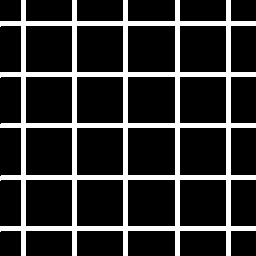

In [20]:
from PIL import Image
Image.open('frame.png')